# Interactions - where are you?

Questions:

- Which interactions are strongest in a ML model?
- How do they look like?

## What makes the box black?

- A model without interactions is an *additive* model of the form
  $$
    f(x) = \beta_0 + f_1(x_1) + f_2(x_2) + \dots + f_m(x_m)
  $$
  with feature vector $x = (x_1, x_2, \dots, x_m)$, and a constant $\beta_0$. The $f_j$ explain the model 100%.
- Interaction: Effect of one feature depends on the values of other features.
- Tree-based models and neural networks typically contain many and complex interactions.
- A model with interactions can be written as its ANOVA decomposition, i.e.,
  $$
    f(x) = \beta_0 + \sum_j^m f_j(x_j) + \sum_{j < k} f_{j, k}(x_j, x_k) + \sum_{j < k < \ell} f_{j, k, \ell}(x_j, x_k, x_\ell) + ... 
  $$
  
## Techniques to identify or describe interactions

1. Individual conditional expectations [1].
2. Stratified or 2D partial dependence.
3. Friedman's H statistics [2].
4. SHAP dependence / SHAP interactions [3].
5. ...

The first three methods work for any model, while SHAP is sufficiently fast mainly for tree-based models.

**References**

1. Goldstein, Alex, and Adam Kapelner and Justin Bleich and Emil Pitkin. *Peeking inside the black box: Visualizing statistical learning with plots of individual conditional expectation.* Journal of Computational and Graphical Statistics, 24, no. 1 (2015): 44-65. https://doi.org/10.1080/10618600.2014.907095.
2. Friedman, Jerome H., and Bogdan E. Popescu. *Predictive Learning via Rule Ensembles.* The Annals of Applied Statistics 2, no. 3 (2008): 916-54. https://doi.org/10.1214/07-AOAS148.
3. Lundberg, S. M., Erion, G., Chen, H. et al. *From local explanations to global understanding with explainable AI for trees.* Nature Machine Intelligence 2, 56–67 (2020). https://doi.org/10.1038/s42256-019-0138-9

## Data and model

For illustration, we use XGBoost to model claim counts (`claim_nb`) as function of features like `driver_age` etc:
$$
    \log(E(\text{claim count} \mid X = x)) = f(x)
$$
The dataset is publicly available. It was generated by simulating from a known model that contains a single interaction between `town` and `car_weight` (on log scale).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


if False:  # Fetch from OpenML
    from sklearn.datasets import fetch_openml
    
    df = fetch_openml(data_id=45106, parser="pandas").frame
else:     # Fetch from repo
    df = pd.read_parquet("df.parquet")
df

,year,town,driver_age,car_weight,car_power,car_age,claim_nb
0,2018.0,1.0,51.0,1760.0,173.0,3.0,0
1,2019.0,1.0,41.0,1760.0,248.0,2.0,0
2,2018.0,1.0,25.0,1240.0,111.0,2.0,0
3,2019.0,0.0,40.0,1010.0,83.0,9.0,0
4,2018.0,0.0,43.0,2180.0,169.0,5.0,0
...,...,...,...,...,...,...,...
999995,2019.0,1.0,45.0,1090.0,62.0,2.0,0
999996,2019.0,1.0,45.0,1180.0,93.0,4.0,0
999997,2018.0,1.0,31.0,1060.0,57.0,1.0,0
999998,2019.0,1.0,28.0,1910.0,149.0,0.0,0


## Univariate description

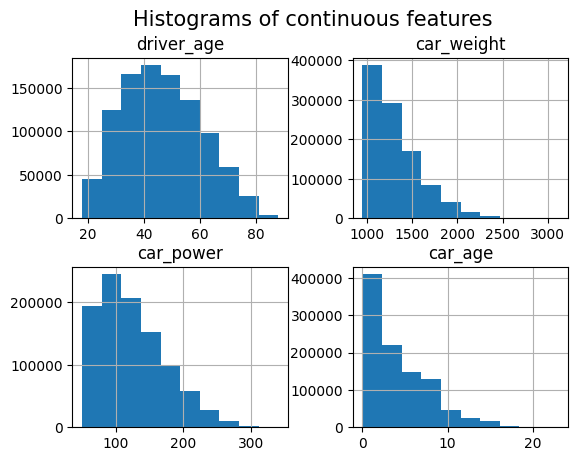

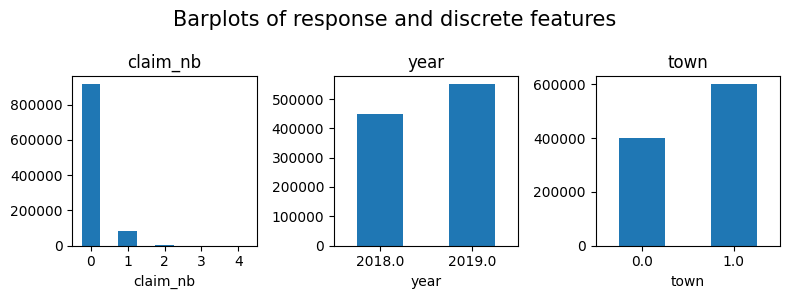

In [2]:
# Continuous
df.hist(["driver_age", "car_weight", "car_power", "car_age"])
_ = plt.suptitle("Histograms of continuous features", fontsize=15)

# Discrete
fig, axes = plt.subplots(figsize=(8, 3), ncols=3)

for v, ax in zip(["claim_nb", "year", "town"], axes):
    df[v].value_counts(sort=False).sort_index().plot(kind="bar", ax=ax, rot=0, title=v)
plt.suptitle("Barplots of response and discrete features", fontsize=15)
plt.tight_layout()

### Modeling

- Since we are modeling counts, we use Poisson deviance loss.
- Parameters have been tuned via random search CV combined with early stopping.

In [3]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor


X_train, X_test, y_train, y_test = train_test_split(
    df.drop("claim_nb", axis=1), df["claim_nb"], test_size=0.1, random_state=30
)
feature_names = X_train.columns.tolist()

dtrain = xgb.DMatrix(X_train, label=y_train)

#### Parameter tuning

In [4]:
if False:  # Set to True to re-run CV
    from sklearn.model_selection import ParameterSampler

    grid = ParameterSampler(
        {
            "objective": ["count:poisson"],
            "learning_rate": [0.1],  # set to end up with healthy amount of trees
            "max_depth": [2, 3, 4],
            "colsample_bynode": [0.8, 1],
            "subsample": [0.8, 1],
            "reg_lambda": [0, 1, 2],
            "reg_alpha": [0, 1, 2],
            "min_split_loss": [0, 0.0001],
            "max_delta_step": [0.1, 0.7],
        },
        n_iter=32,
        random_state=4,
    )

    search = []
    for g in grid:
        print(".", end="")
        cvm = xgb.cv(
            params=g,
            dtrain=dtrain,
            num_boost_round=5000,
            nfold=5,
            seed=60,
            early_stopping_rounds=20,
            # callbacks=[xgb.callback.EvaluationMonitor(period=50)],
        )
        # Keep number of rounds, cv score, train score, and parameters
        result = (len(cvm) - 1, *cvm.iloc[-1, [2, 0]], g)
        search.append(result)
    
    search_df = pd.DataFrame.from_records(
        search, columns=["num_boost_round", "cv_score", "train_score", "params"]
    ).sort_values("cv_score")
    with pd.option_context("display.max_colwidth", None):
        display(search_df)

num_rounds = 317

#### Fit with best parameters

In [5]:
params = {
    "objective": "count:poisson",
    "learning_rate": 0.1,
    "max_depth": 2,
    "colsample_bynode": 1,
    "subsample": 0.8,
    "reg_lambda": 2,
    "reg_alpha": 2,
    "min_split_loss": 0,
    "max_delta_step": 0.7,
}

model = XGBRegressor(
    n_estimators=num_rounds, **params, importance_type="gain", random_state=109
)
_ = model.fit(X_train, y_train)

#### Variable importance

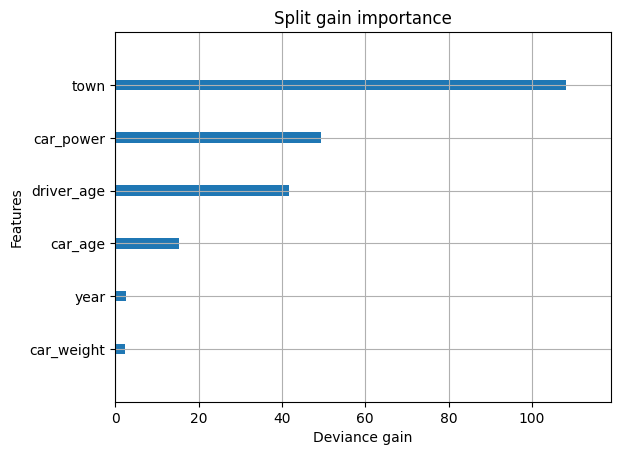

In [6]:
_ = xgb.plot_importance(
    model, 
    importance_type="gain",
    xlabel="Deviance gain",
    title="Split gain importance",
    show_values=False
)

### Local GLM Net

In [7]:
import torch
from torch import nn
from localglmnet import LocalGLMNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(5550222340)

In [8]:
transformer_town = FunctionTransformer(lambda x: x - 0.5)
vars_rescale = ["year", "driver_age", "car_weight", "car_power", "car_age"]
preproc = ColumnTransformer(
    [
        ("StandardScaler", MinMaxScaler(), vars_rescale),
        ("Town", transformer_town, ["town"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")
# X_train_nn = X_train.copy()
# X_train_nn["town"] -= 0.5
X_train_nn = preproc.fit_transform(X_train)
X_train_nn

,year,driver_age,car_weight,car_power,car_age,town
39500,0.0,0.528571,0.082949,0.134021,0.478261,0.5
870502,0.0,0.085714,0.055300,0.243986,0.304348,0.5
537873,0.0,0.242857,0.239631,0.281787,0.000000,0.5
521719,0.0,0.742857,0.069124,0.061856,0.086957,-0.5
816151,0.0,0.700000,0.096774,0.144330,0.000000,-0.5
...,...,...,...,...,...,...
570508,0.0,0.157143,0.023041,0.030928,0.130435,0.5
885236,0.0,0.342857,0.359447,0.336770,0.000000,0.5
572333,1.0,0.100000,0.032258,0.216495,0.043478,-0.5
987557,1.0,0.428571,0.101382,0.065292,0.086957,-0.5


In [9]:
y0 = np.log(y_train.mean())

In [10]:
model_torch = LocalGLMNet(X_train_nn.shape[1])

def custom_init_weights(m, final_layer_name, bias_value):
    if isinstance(m, nn.Linear):
        if m is dict(model_torch.named_modules())[final_layer_name]:
            nn.init.constant_(m.bias, bias_value)
            nn.init.constant_(m.weight, 0.)
final_layer_name = "output_layer"
model_torch.apply(lambda m: custom_init_weights(m, final_layer_name, y0))
model_torch

LocalGLMNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=6, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=30, bias=True)
  )
  (last_hidden_layer): Linear(in_features=30, out_features=6, bias=True)
  (output_layer): Linear(in_features=1, out_features=1, bias=True)
  (activation): Tanh()
)

In [11]:
dataset = TensorDataset(
    torch.tensor(X_train_nn.values, dtype=torch.float, ),
    torch.tensor(y_train, dtype=torch.float, ),
    )
dataloader = DataLoader(dataset, batch_size=5_000, shuffle=True)
optimizer = torch.optim.Adam(model_torch.parameters())
num_epochs = 10
loss_fn = nn.PoissonNLLLoss(log_input=False, reduction="mean")
for epoch in range(num_epochs):
    model_torch.train()
    total_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()
        x_batch, y_batch = batch
        outputs = model_torch(x_batch)
        loss = loss_fn(torch.flatten(outputs), torch.flatten(y_batch))        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

Epoch [1/10], Loss: 0.3029
Epoch [2/10], Loss: 0.3017
Epoch [3/10], Loss: 0.3014
Epoch [4/10], Loss: 0.3008
Epoch [5/10], Loss: 0.3005
Epoch [6/10], Loss: 0.3004
Epoch [7/10], Loss: 0.3003
Epoch [8/10], Loss: 0.3003
Epoch [9/10], Loss: 0.3002
Epoch [10/10], Loss: 0.3002


In [12]:
model_torch.eval()
x_eval = torch.tensor(preproc.transform(X_test).values, dtype=torch.float)
with torch.no_grad():
    pred_torch = model_torch(x_eval)
print(pred_torch.mean())
print(y_test.mean())

tensor(0.0910)
0.08896


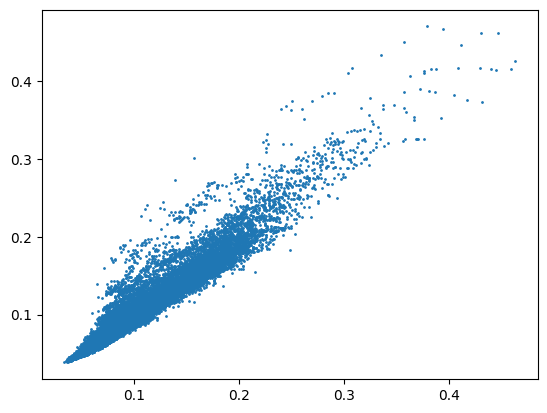

In [13]:
plt.scatter(pred_torch, model.predict(X_test), s=1)

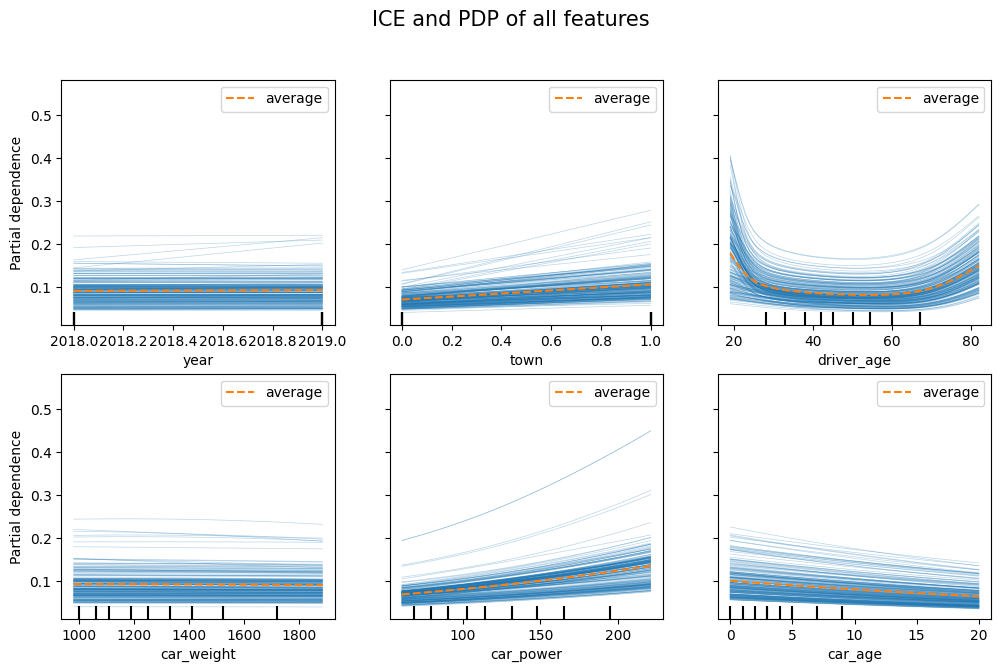

In [14]:
from sklearn.inspection import PartialDependenceDisplay

class Dummy:
    def __init__(self, model, preproc):
        self.model = model
        self._estimator_type = "regressor"
        self.preproc = preproc
        
    def __sklearn_is_fitted__(self):
        return True
    
    def fit(self):
        pass

    def predict(self, _X, attentions=False):
        self.model.eval()
        X = _X.copy()
        X["town"] -= 0.5
        X = preproc.transform(_X)
        dataset = TensorDataset(
        torch.tensor(X.values, dtype=torch.float, ),
        torch.tensor(X.values, dtype=torch.float, ),
        )
        dataloader = DataLoader(dataset, batch_size=1_000_000, shuffle=False) 
        for batch in dataloader:
            x_batch, y_batch = batch
            with torch.no_grad():  # No gradient computation
                pred_torch = self.model(x_batch, attentions=attentions)
        return pred_torch.numpy()

# Pick some rows to explain
X_explain = X_train.sample(n=1000, random_state=937)

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle("ICE and PDP of all features", fontsize=15)

_= PartialDependenceDisplay.from_estimator(
    Dummy(model_torch, preproc), 
    X=X_explain, 
    features=X_explain.columns, 
    kind="both",
    ax=axes,
    subsample=200,
)

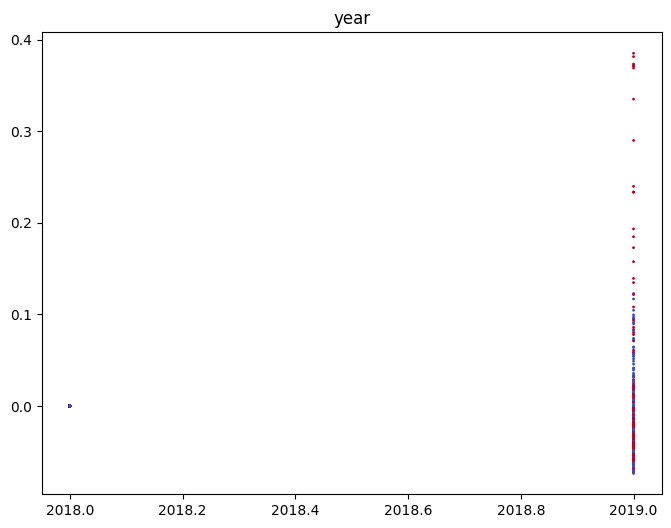

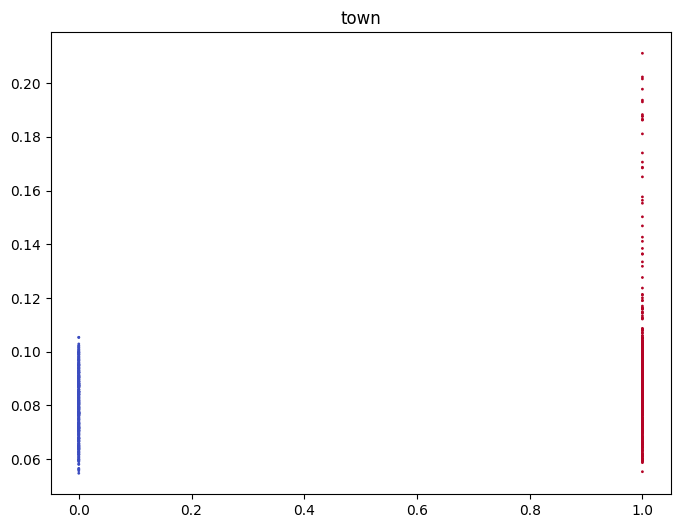

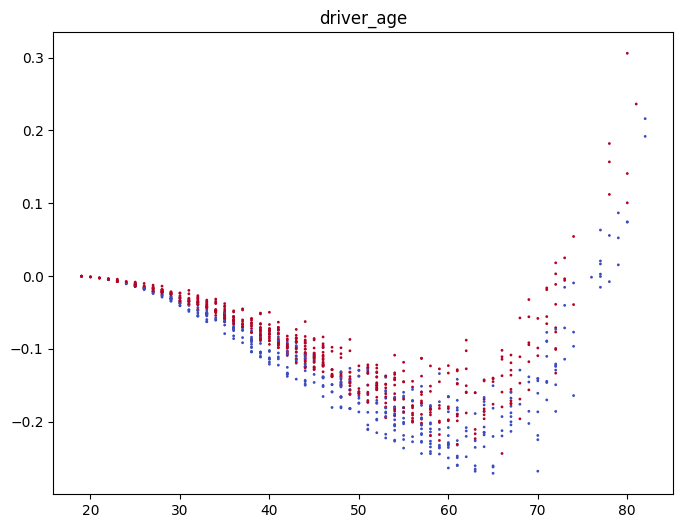

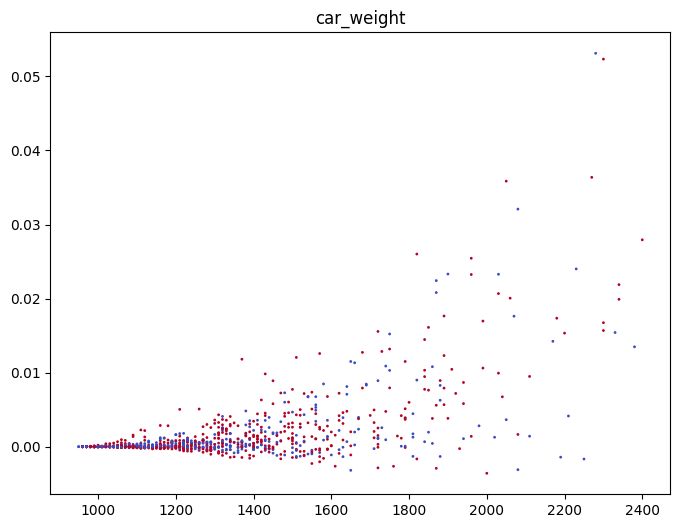

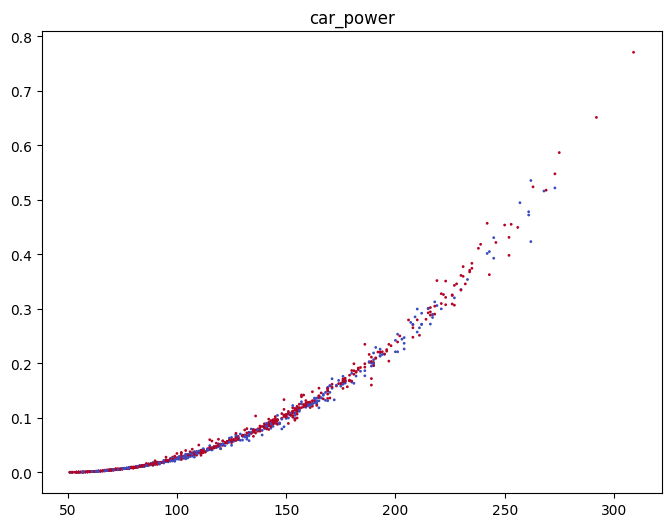

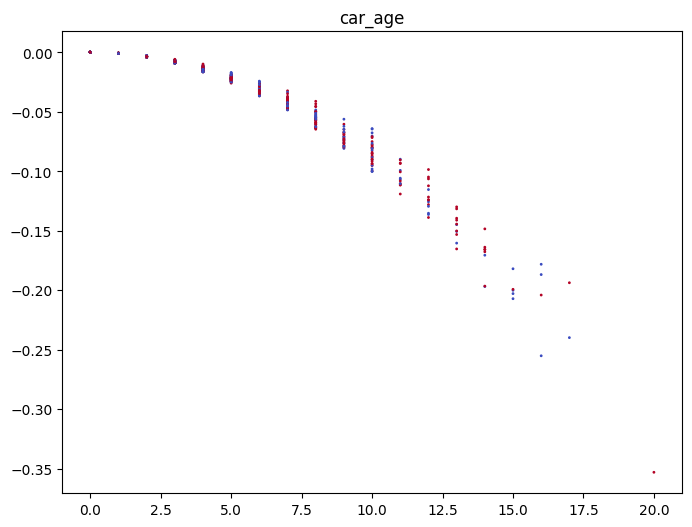

In [15]:
cols_nn_X = X_train_nn.columns
mod_explain_nn = Dummy(model_torch, preproc)
betas_torch = mod_explain_nn.predict(X_explain, attentions=True)
# betas_torch *= mod_explain_nn.model.output_layer.weight.detach().numpy()
attentions = betas_torch * preproc.transform(X_explain).values
mod_explain_nn = Dummy(model_torch, preproc)
contributions = attentions * mod_explain_nn.model.output_layer.weight.detach().numpy()
for col in X_explain.columns:
    mask_col_nn = [el == col for el in cols_nn_X]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(col)
    ax.scatter(
        X_explain[col],
        contributions[:, mask_col_nn].flatten() * preproc.transform(X_explain)[col].values,
        s=1,
        c=X_explain["town"],
        cmap=plt.cm.coolwarm
    )

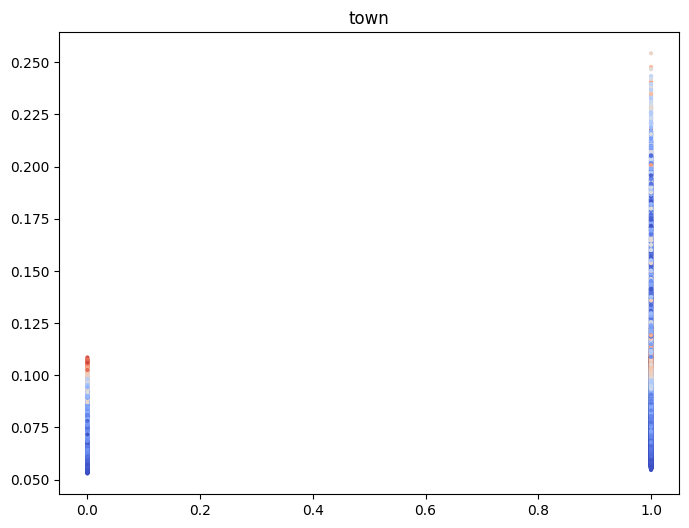

In [34]:
col = "town"
betas_torch = mod_explain_nn.predict(X_test, attentions=True)
# betas_torch *= mod_explain_nn.model.output_layer.weight.detach().numpy()
attentions = betas_torch * preproc.transform(X_test).values
mod_explain_nn = Dummy(model_torch, preproc)
contributions = attentions * mod_explain_nn.model.output_layer.weight.detach().numpy()
mask_col_nn = [el == col for el in cols_nn_X]
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(col)
ax.scatter(
    X_test[col],
    contributions[:, mask_col_nn].flatten() * preproc.transform(X_test)[col].values,
    s=4,
    c=X_test["car_power"],
    cmap=plt.cm.coolwarm
)

## Digging into interactions

### Individual conditional expectations (ICE)

Let's have a look at feature effects first. 

The ICE curve of a feature $X_j$ shows how the predictions of an observation change with varying values of $X_j$, keeping everything else fixed (Ceteris Paribus).

*The average over all curves estimates the partial dependence function* $PD_j(v)$.

- We evaluate the model predictions on log scale. (Poisson loss uses a log link in the background.)
- If the model would not contain interactions, the ICE curves of a feature would be parallel.
- Here, it is not the case. Thus, the model contains interactions.
- But between which variables?

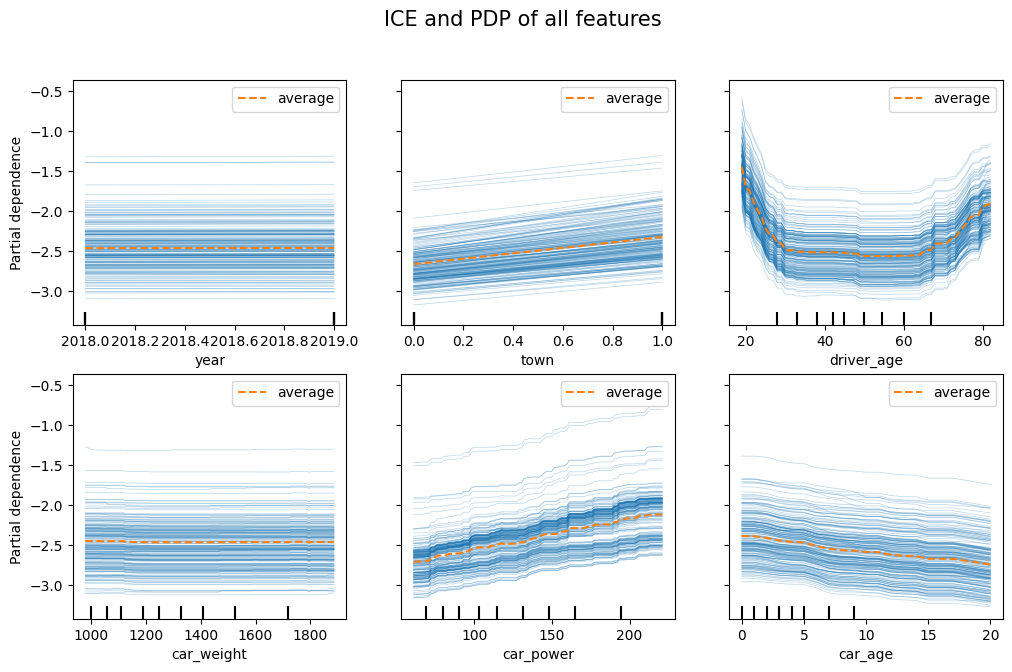

In [16]:
from sklearn.inspection import PartialDependenceDisplay
from logregressor import LogRegressor

# Pick some rows to explain
X_explain = X_train.sample(n=1000, random_state=937)

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle("ICE and PDP of all features", fontsize=15)

_= PartialDependenceDisplay.from_estimator(
    LogRegressor(model), 
    X=X_explain, 
    features=X_explain.columns, 
    kind="both",
    ax=axes,
    subsample=200,
)

Two-dimensional partial dependence functions $PD_{jk}(v, w)$ visualize the combined effect of two features. They are hard to read.

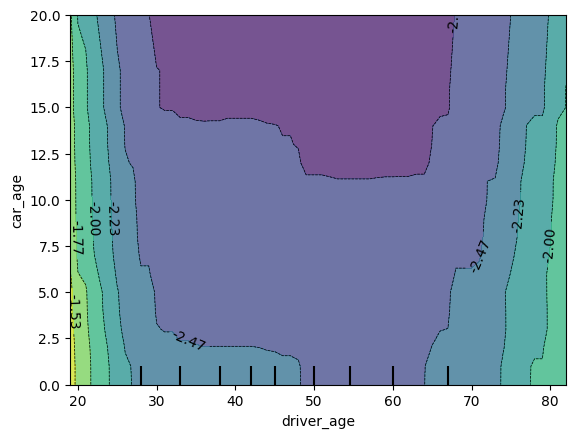

In [17]:
_= PartialDependenceDisplay.from_estimator(
    LogRegressor(model), X=X_explain, features=[("driver_age", "car_age")]
)

### Friedman's H statistics

If a model is additive in features $X_j$ and $X_k$, their two-dimensional partial dependence function equals the sum of the two one-dimensional partial dependence functions, i.e.,
$$
    PD_{jk}(v, w) = PD_{j}(v) + PD_{k}(w).
$$
(All functions are centered to 0.)

Friedman's $H^2$ statistic uses squared deviation from above equation to measure non-additivity, i.e.,
$$
  H_{jk}^2 = \frac{\frac{1}{n} \sum_{i = 1}^n\big[\widehat{PD}_{jk}(x_{ij}, x_{ik}) -\widehat{PD}_j(x_{ij}) - \widehat{PD}_k(x_{ik})\big]^2}{\frac{1}{n} \sum_{i = 1}^n\big[\widehat{PD}_{jk}(x_{ij}, x_{ik})\big]^2},
$$
where the sums run over a data subset of $n \approx 500$ observations. 

- $H_{jk}^2$ is interpreted as the proportion of joint effect variability unexplained by the main effects.
- Computational complexity to calculate pairwise statistics for $m$ features is $O(n^2 m^2)$.
- When the joint effect (= denominator) is weak, even a weak interactions can get high $H_{jk}^2$.
- Thus, it makes sense to focus on important features only.

In [18]:
# Modified from https://github.com/scikit-learn/scikit-learn/pull/28375
from hstats import h_statistic

important_features = ["town", "driver_age", "car_power", "car_age"]  # via split gain

H2 = h_statistic(
    LogRegressor(model), X=X_train, features=important_features, random_state=1,
)

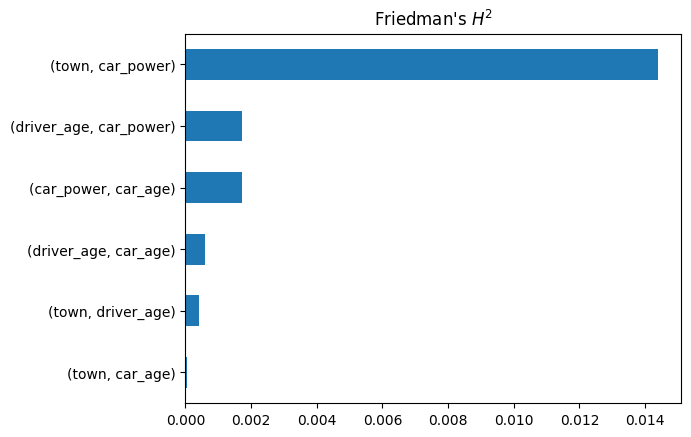

In [19]:
H2 = pd.DataFrame(
    H2["h_squared_pairwise"], H2["feature_pairs"], columns=["H_squared"]
).sort_values("H_squared")
_ = H2.plot.barh(title="Friedman's $H^2$", legend=False)

One interaction is clearly stronger than the others. Still, it explains only 1.4% of the joint effect variability.

Let's visualize it by a **stratified** partial dependence plot. We can see that the car power effect is stronger in towns (town = 1) than on the countryside (town = 0).

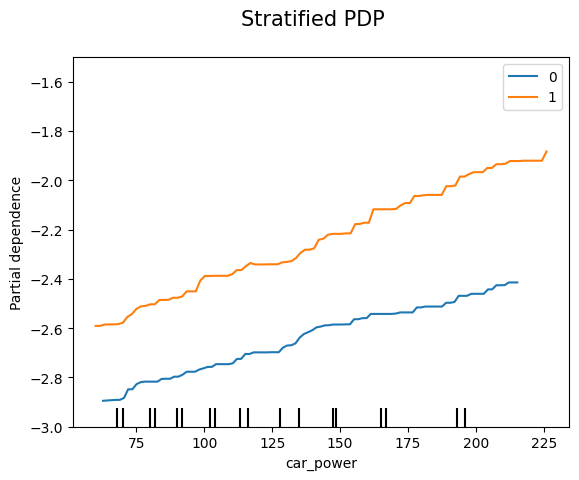

In [20]:
for color, town in zip(("tab:blue", "tab:orange"), (0, 1)):
    disp = PartialDependenceDisplay.from_estimator(
        LogRegressor(model),
        features=["car_power"],
        X=X_explain[X_explain.town == town],
        ax=None if town == 0 else disp.axes_,
        line_kw={"label": town, "color": color},
    )
plt.ylim(-3, -1.5)
_ = plt.suptitle("Stratified PDP", fontsize=15)
# how to remove the deciles at the bottom?

### SHAP

SHAP values decompose (centered raw) predictions into feature contributions. To study a model, many predictions are decomposed and analyzed with simple plots.

- SHAP importance is measured as mean absolute SHAP value per feature.
- SHAP dependence plots show the functional form of the effect. Vertical scatter and coloring gives hints about interactions.

Again, we can spot that the car power effect is stronger in town.

/Users/marcom/WorkArea/interactions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


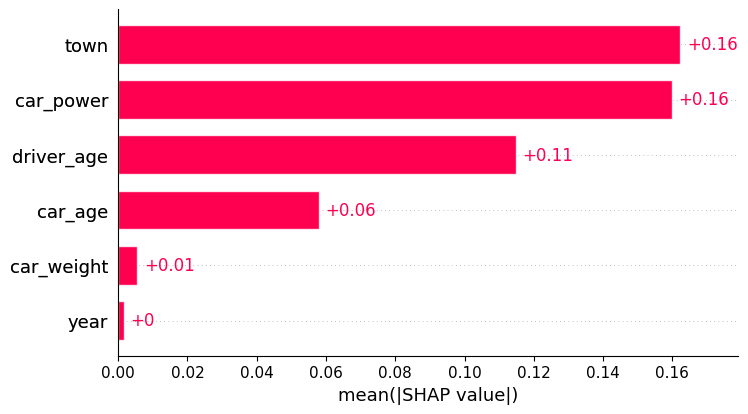

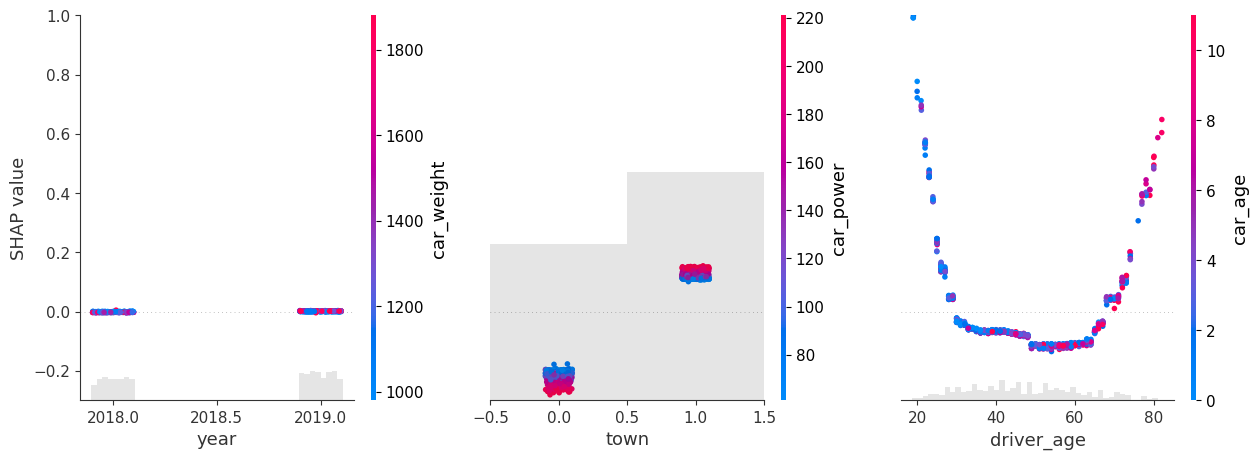

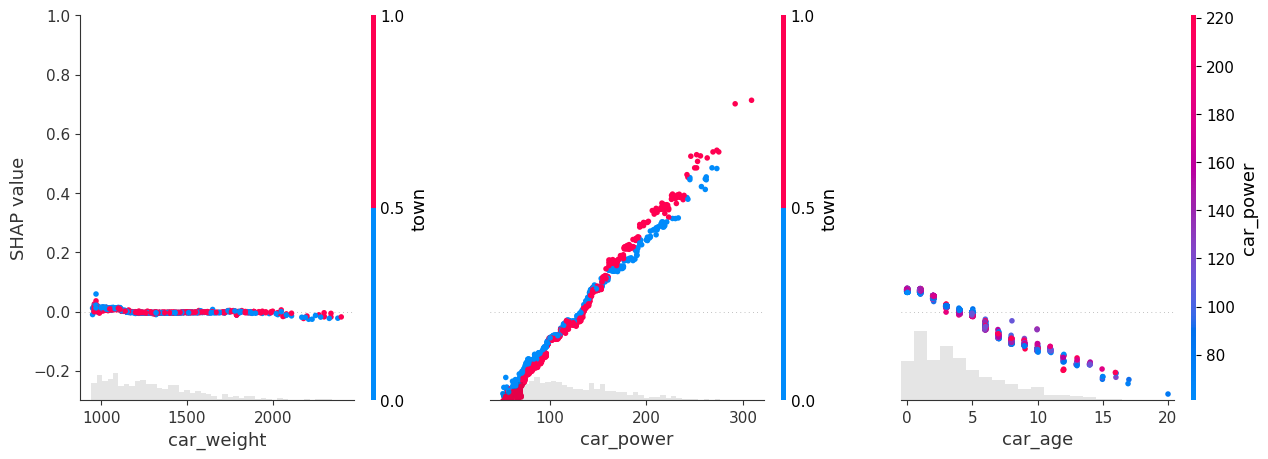

In [21]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_explain)

shap.plots.bar(shap_values)

for s in [shap_values[:, 0:3], shap_values[:, 3:]]:
    shap.plots.scatter(s, color=shap_values, ymin=-0.3, ymax=1)

### SHAP Interactions

SHAP interactions decompose predictions into contributions of *feature pairs*. For the ease of interpretability, the main effects are separated from the pairwise values.

In [22]:
shap_interactions = explainer(X_explain, interactions=True)
print("Dimension is n x p x p:", shap_interactions.values.shape)

Dimension is n x p x p: (1000, 6, 6)


The sum of all SHAP interactions of an observation indeed equals (approximately) the "raw" centered prediction:

In [23]:
shap_interactions.values[0].sum() + shap_interactions.base_values[0]

-2.6691616

In [24]:
model.predict(X_explain.head(1), output_margin=True)

array([-2.6691606], dtype=float32)

#### Mean absolute SHAP interactions

Let's calculate mean absolute SHAP interaction values per feature pair.

In [25]:
def shap_interaction_importance(shap_interactions, feature_names):
    """Calculates the importance of interactions from SHAP interaction values.
    
    Parameters:
    ===========
    shap_interactions: The result of `explainer(X_explain, interactions=True)`.
    feature_names: list of feature names corresponding to shap_interactions.

    Returns:
    ========
    DataFrame with columns "Features", "Importance", "Main_effect" (boolean), sorted
      by importance in descending order.
    """
    if shap_interactions.values.ndim != 3:
        raise ValueError("SHAP interaction values must be a 3D array")
    if len(feature_names) != shap_interactions.values.shape[1]:
        raise ValueError("Number of feature names inconsistent with SHAP interactions")

    M = np.abs(shap_interactions.values).mean(axis=0)
    M += M.T - np.diag(M.diagonal())  # Off-diagonals twice
    ix = np.tril_indices(M.shape[0])

    importances = []
    for i, j in zip(ix[0], ix[1]):
        feat = feature_names[i] + ":" + feature_names[j] if i != j else feature_names[i]
        importances.append((feat, M[i, j], i == j))

    df = pd.DataFrame(importances, columns=("Features", "Importance", "Main_effect"))

    return df.sort_values("Importance", ascending=False)

We can immediately spot the strongest interaction, and how it compares with the main effect strength:

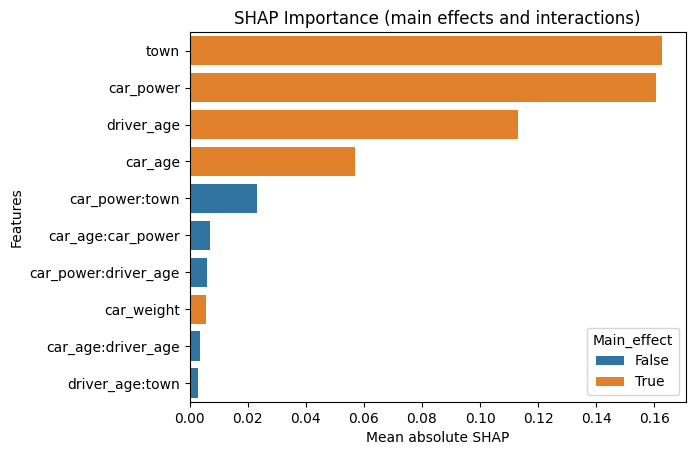

In [26]:
shap_inter_imp = shap_interaction_importance(
    shap_interactions, X_explain.columns
).head(10)
ax = sns.barplot(
    data=shap_inter_imp, y="Features", x="Importance", hue="Main_effect", orient="h"
)
_ = ax.set(
    xlabel="Mean absolute SHAP",
    title="SHAP Importance (main effects and interactions)"
)

Let's visualize the strongest interaction via SHAP dependence plot. Again, we see that the combination of strong cars with town is associated with higher (log) frequency.

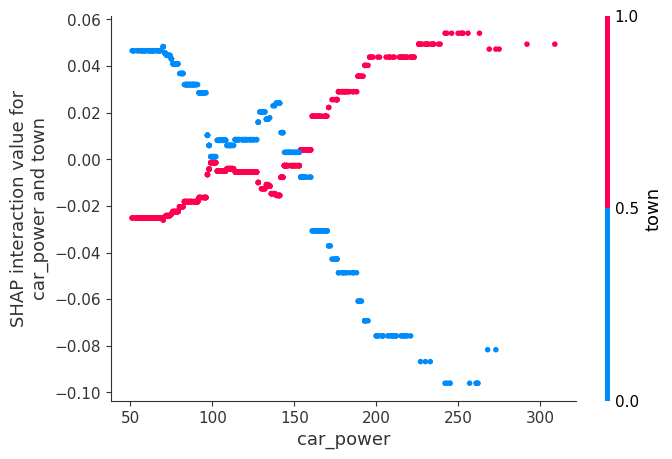

In [27]:
shap.dependence_plot(("car_power", "town"), shap_interactions.values, X_explain)

And the main effect of `car_power`:

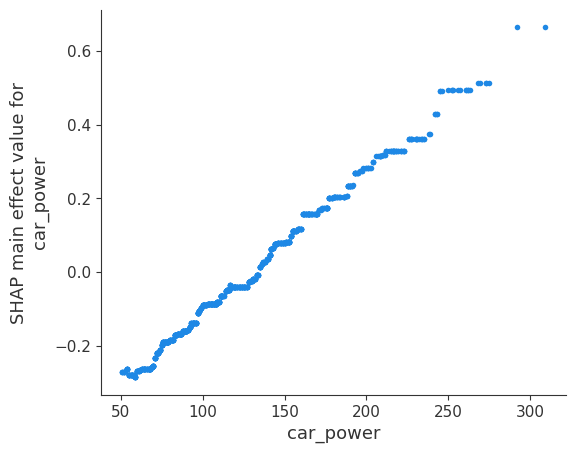

In [28]:
shap.dependence_plot(("car_power", "car_power"), shap_interactions.values, X_explain)

## Wrap-up

- Interactions can be investigated for any model via ICE/stratified PDP/H-statistics.
- For tree-based models, SHAP is sufficiently fast to even study SHAP interaction strength measures.